#Loading the Dataset


In [5]:
import pandas as pd
import numpy as np

# 1) load
df = pd.read_excel("Online Retail.xlsx")

# 2) basic checks
print(df.head())
print(df.info())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       -----------

#Cleaning


In [6]:


df = df.dropna(subset=["CustomerID"])

df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]


df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]


df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


#RFM Analysis


In [7]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = (
    df.groupby("CustomerID").agg(
        Recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
        Frequency=("InvoiceNo", "nunique"),
        Monetary=("TotalPrice", "sum"),
    )
    .reset_index()
)

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [8]:
# rank first to avoid qcut edge/duplicate errors
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1])  # low recency ⇒ 5
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5])
rfm["M_Score"] = pd.qcut(rfm["Monetary"].rank(method="first"), 5, labels=[1,2,3,4,5])

rfm["R_Score"] = rfm["R_Score"].astype(int)
rfm["F_Score"] = rfm["F_Score"].astype(int)
rfm["M_Score"] = rfm["M_Score"].astype(int)

# combined helpers
rfm["RFM_Score"]   = rfm[["R_Score","F_Score","M_Score"]].sum(axis=1)
rfm["RFM_Segment"] = rfm["R_Score"].astype(str)+rfm["F_Score"].astype(str)+rfm["M_Score"].astype(str)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_Segment
0,12346.0,326,1,77183.60,1,1,5,7,115
1,12347.0,2,7,4310.00,5,5,5,15,555
2,12348.0,75,4,1797.24,2,4,4,10,244
3,12349.0,19,1,1757.55,4,1,4,9,414
4,12350.0,310,1,334.40,1,1,2,4,112


In [9]:
def segment_row(r, f, m):

    if r>=4 and f>=4 and m>=4:
        return "Champions"
    if r>=4 and f>=3:
        return "Loyal Customers"
    if r>=3 and f>=3 and m>=3:
        return "Potential Loyalists"
    if r>=4 and f<=2:
        return "New Customers"
    if r<=2 and f>=4:
        return "At Risk"
    if r<=2 and f<=2:
        return "Hibernating"
    return "Needs Attention"

rfm["Segment"] = rfm.apply(lambda x: segment_row(x["R_Score"], x["F_Score"], x["M_Score"]), axis=1)
rfm["Segment"].value_counts()


,count
Segment,
Hibernating,1065
Champions,962
Needs Attention,805
Loyal Customers,491
Potential Loyalists,421
New Customers,319
At Risk,275


#Visualizations


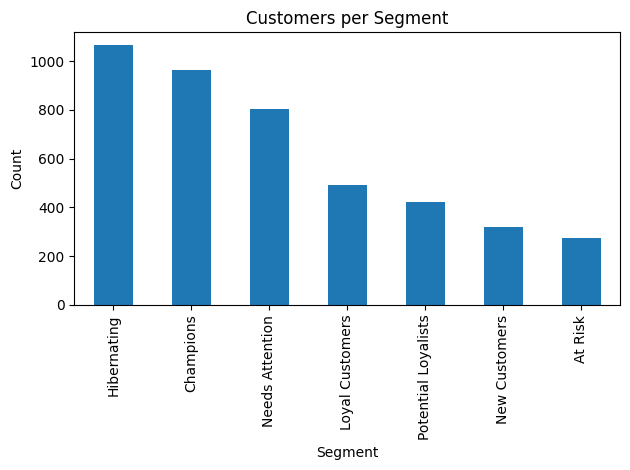

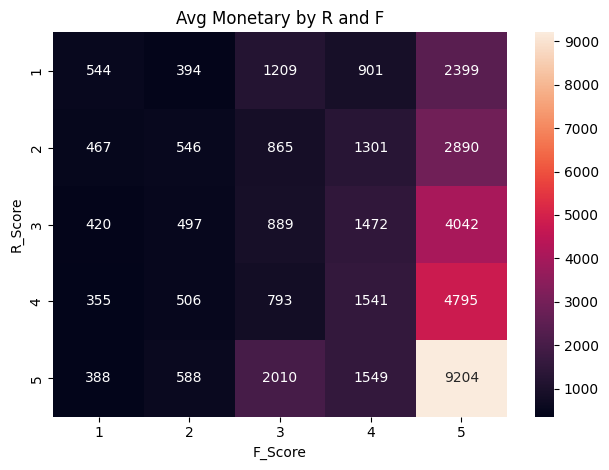

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
rfm["Segment"].value_counts().sort_values(ascending=False).plot(kind="bar")
plt.title("Customers per Segment")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


pivot = rfm.pivot_table(index="R_Score", columns="F_Score", values="Monetary", aggfunc="mean")
plt.figure()
sns.heatmap(pivot, annot=True, fmt=".0f")
plt.title("Avg Monetary by R and F")
plt.tight_layout()
plt.show()


In [11]:
rfm_out = rfm[["CustomerID","Recency","Frequency","Monetary","R_Score","F_Score","M_Score","RFM_Score","Segment"]]
rfm_out.to_csv("rfm_segments.csv", index=False)
print("Saved rfm_segments.csv")


Saved rfm_segments.csv
